In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import model_utils
import plot_utils
import custom_transforms
from dataset import COCO_Person_Dataset
from nn_model import Net
from CONSTANTS import idx_to_keypoint_type
from custom_transforms import *
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import time

In [2]:
#17 keypoints
#'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
#'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 
#'right_knee', 'left_ankle', 'right_ankle'


In [2]:
processed_files = {
    'img_id_to_annotations': 'img_id_to_annotations.npy',
    'img_id_to_image_info' : 'img_id_to_image_info.npy',
    'im_ids' : 'im_ids.npy'
}

In [3]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)

tfms = transforms.Compose([
    RandomCrop(),
    ResizeImgAndKeypoints(368),
    ColorJitter(),
    RandomGrayscale(),
    FlipHR(p=0.5),
    #FlipUD(),
    RandomRotateImgAndKeypoints(deg=30, p=1)
])

tensor_tfms = transforms.Compose([
    ToTensor(),
    NormalizeImg(mean, std)
])

UnNormalize = UnNormalizeImgBatch(mean, std)
To_Pil = transforms.ToPILImage()

In [4]:
bs = 8
ds = COCO_Person_Dataset('train2014/', processed_files, tfms, tensor_tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

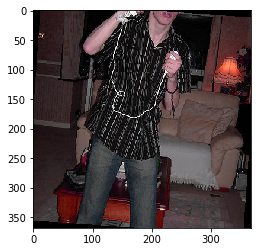

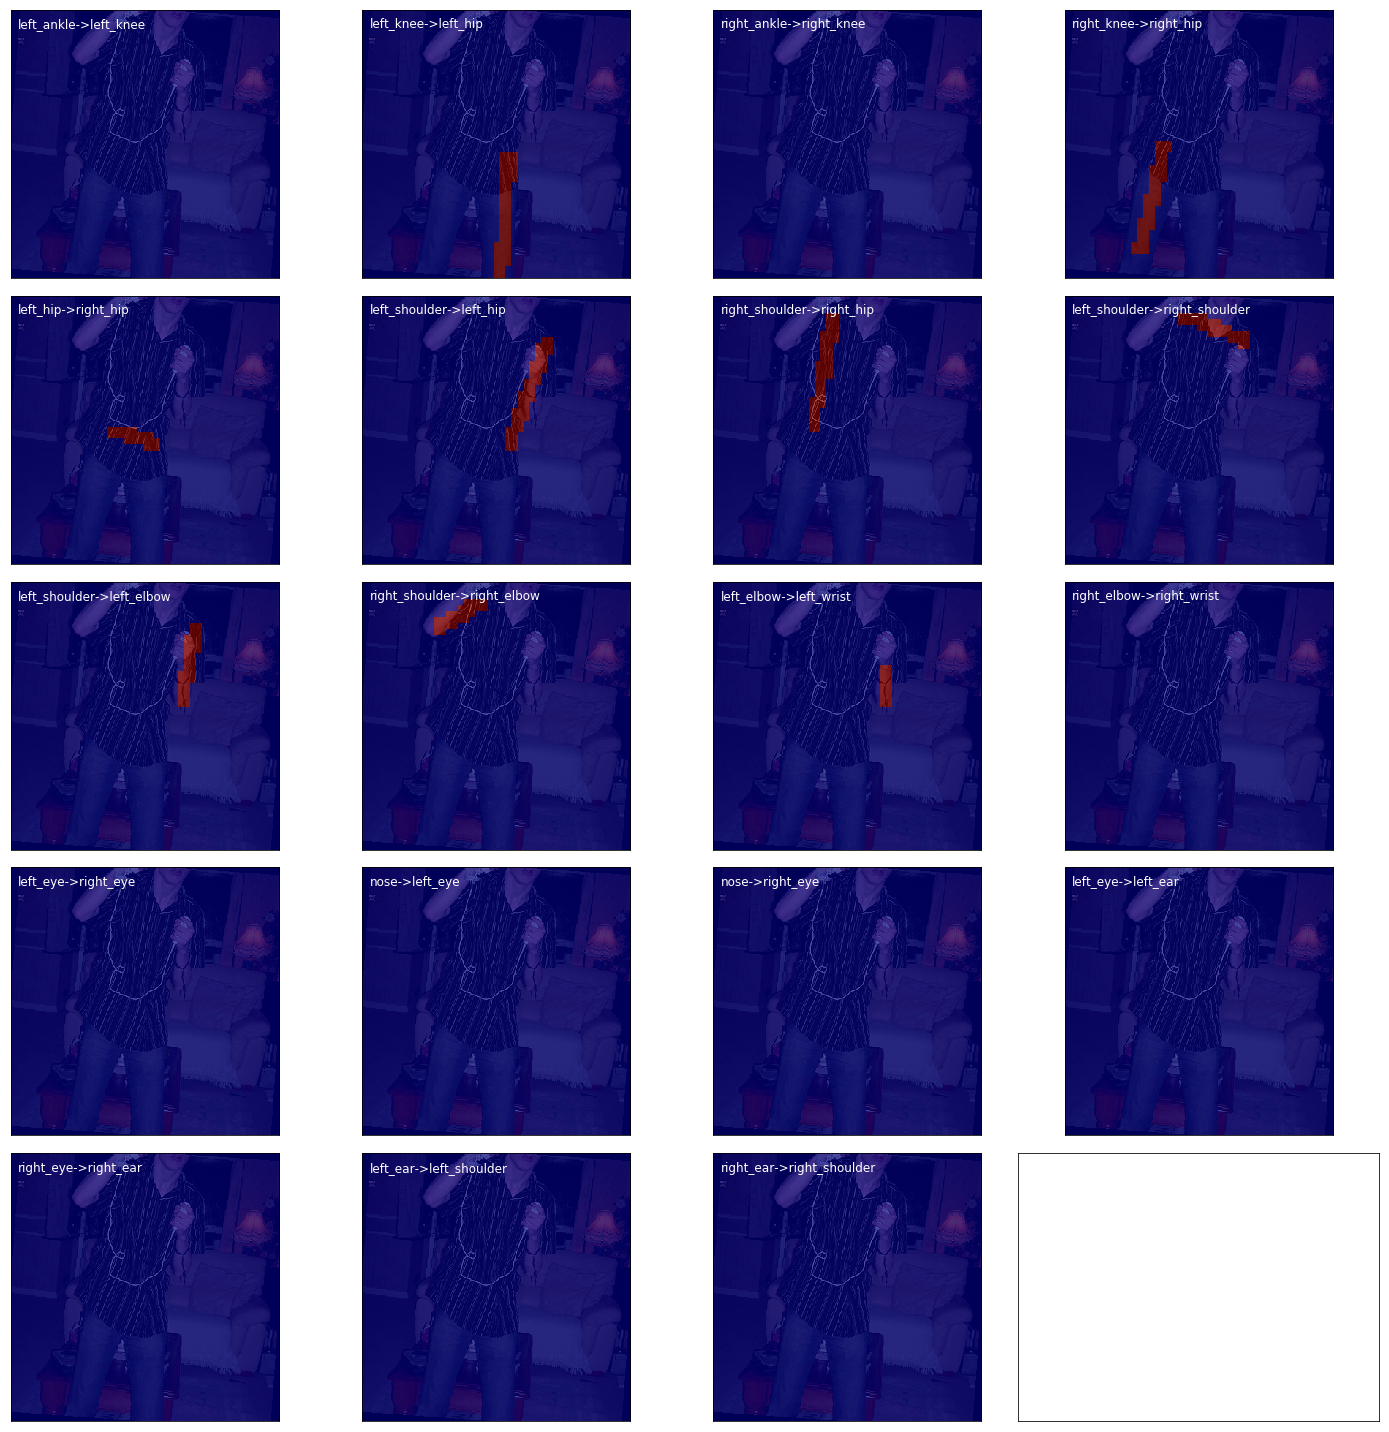

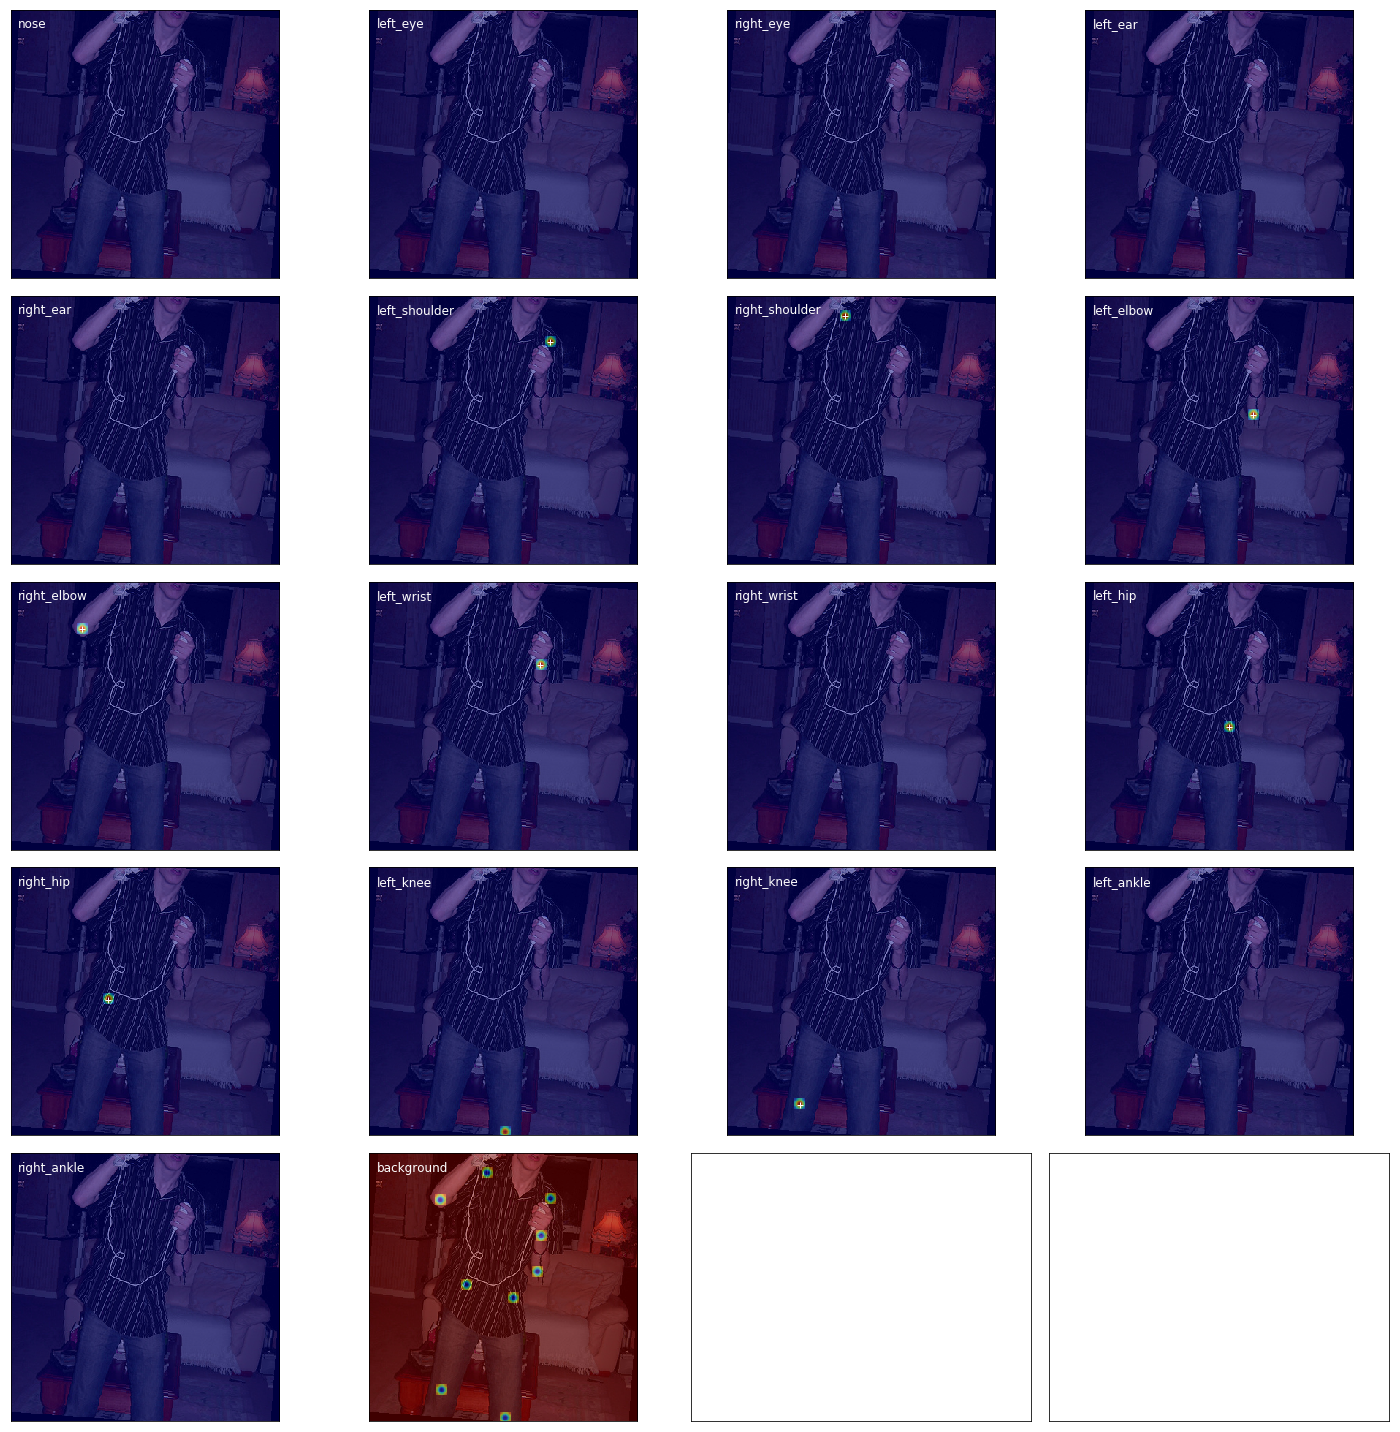

In [6]:
i,i_46x46,pafs,paf_ind,hms,hms_ind = ds[1050]
scaled_pafs = F.interpolate(pafs[None].clone().detach(), 368, mode="bilinear", align_corners=True).to(device)[0] #mode="nearest|area"
#scaled_hms = F.interpolate(hms[None].clone().detach(), 368, mode="bilinear", align_corners=True).to(device)[0]
un_im = To_Pil(UnNormalize(i)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, scaled_pafs.clone().detach().cpu().numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hms.clone().detach().cpu().numpy(), figsize=(20,20))

In [8]:
%%time 
for x,y,z,a,b,c in dl:
    break   

CPU times: user 372 ms, sys: 64 ms, total: 436 ms
Wall time: 473 ms


In [5]:
model = Net(in_training=True)
model.load_state_dict(torch.load('hm-stage2-new-opt.ckpt'))

model.unfreeze_F()
model.train_paf_stage(4)
model.unfreeze_all_paf_stages()

model.train_hm_stage(2)
model.unfreeze_all_hm_stages()

model.to(device)

Net(
  (F): F(
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [8]:
for p in model.Heatmap_Stages.Stage1.parameters():
    p.requires_grad = True

In [ ]:
for p in model.parameters():
    print(p.requires_grad)

In [8]:
model.train()
n_epochs = 3
lr = 0.0001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0

for e in range(n_epochs):
    for imgs, imgs_46x46, pafs, paf_inds, hms, hm_inds in dl:
        optimizer.zero_grad()
        
        imgs, imgs_46x46, pafs, paf_inds, hms, hm_inds = imgs.to(device), imgs_46x46.to(device), pafs.to(device), paf_inds.to(device), hms.to(device), hm_inds.to(device) 
        pred_pafs, pred_hms = model(imgs, imgs_46x46)
        loss = model_utils.paf_and_heatmap_loss(pred_pafs, pafs, paf_inds, pred_hms, hms, hm_inds)
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
        if(total_steps%250==0):
            torch.save(model.state_dict(),'hm-stage2-new-opt.ckpt')
            print('saving model')
                                                       
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

Epoch [1/3], Iteration [1/5647], Loss: 971.0178
Epoch [1/3], Iteration [10/5647], Loss: 906.1688


ValueError: could not broadcast input array from shape (15,15) into shape (15,14)

In [ ]:
#torch.save(model.state_dict(),'stage1-trained.ckpt')

In [19]:
%%time
with torch.no_grad():
    model.eval()
    model.set_to_inference()
    imgs,imgs_46x46, _, _, _, _ = iter(dl).next()
    pred_pafs_stages, pred_hms_stages = model(imgs.to(device), imgs_46x46.to(device))
    scaled_pafs = F.interpolate(pred_pafs_stages.clone().detach(), 368, mode="bilinear", align_corners=True).to(device)
    scaled_hms = F.interpolate(pred_hms_stages.clone().detach(), 368, mode="bilinear", align_corners=True).to(device)

CPU times: user 9.12 s, sys: 1.01 s, total: 10.1 s
Wall time: 10.2 s


In [ ]:
idx = 5
im = imgs[idx]
pf = scaled_pafs[idx].clone()
hm = scaled_hms[idx].clone()
pf[torch.abs(pf)<1e-1] = 0
hm[torch.abs(hm)<1e-1] = 0

un_im = To_Pil(un(im)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, pf.cpu().numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hm.cpu().numpy(), figsize=(20,20))

In [6]:
test_tensor_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
stride = 2
R_368x368 = Resize(368//stride)
R_46x46 = transforms.Resize(46//stride)

test_img_368x368 = R_368x368(Image.open('./test-images/6.jpg'))
test_img_46x46 = R_46x46(test_img_368x368)

im = test_tensor_tfms(test_img_368x368)[:3]
im_46x46 = test_tensor_tfms(test_img_46x46)[:3]

/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


In [27]:
with torch.no_grad():
    model.eval()
    pred_pafs_stages, pred_hms_stages = model(im[None].to(device), im_46x46[None].to(device))
    scaled_pafs = F.interpolate(pred_pafs_stages, 368//stride, mode="bilinear", align_corners=True).to(device)
    scaled_hms = F.interpolate(pred_hms_stages, 368//stride, mode="bilinear", align_corners=True).to(device)

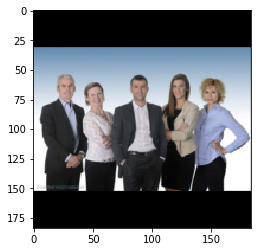

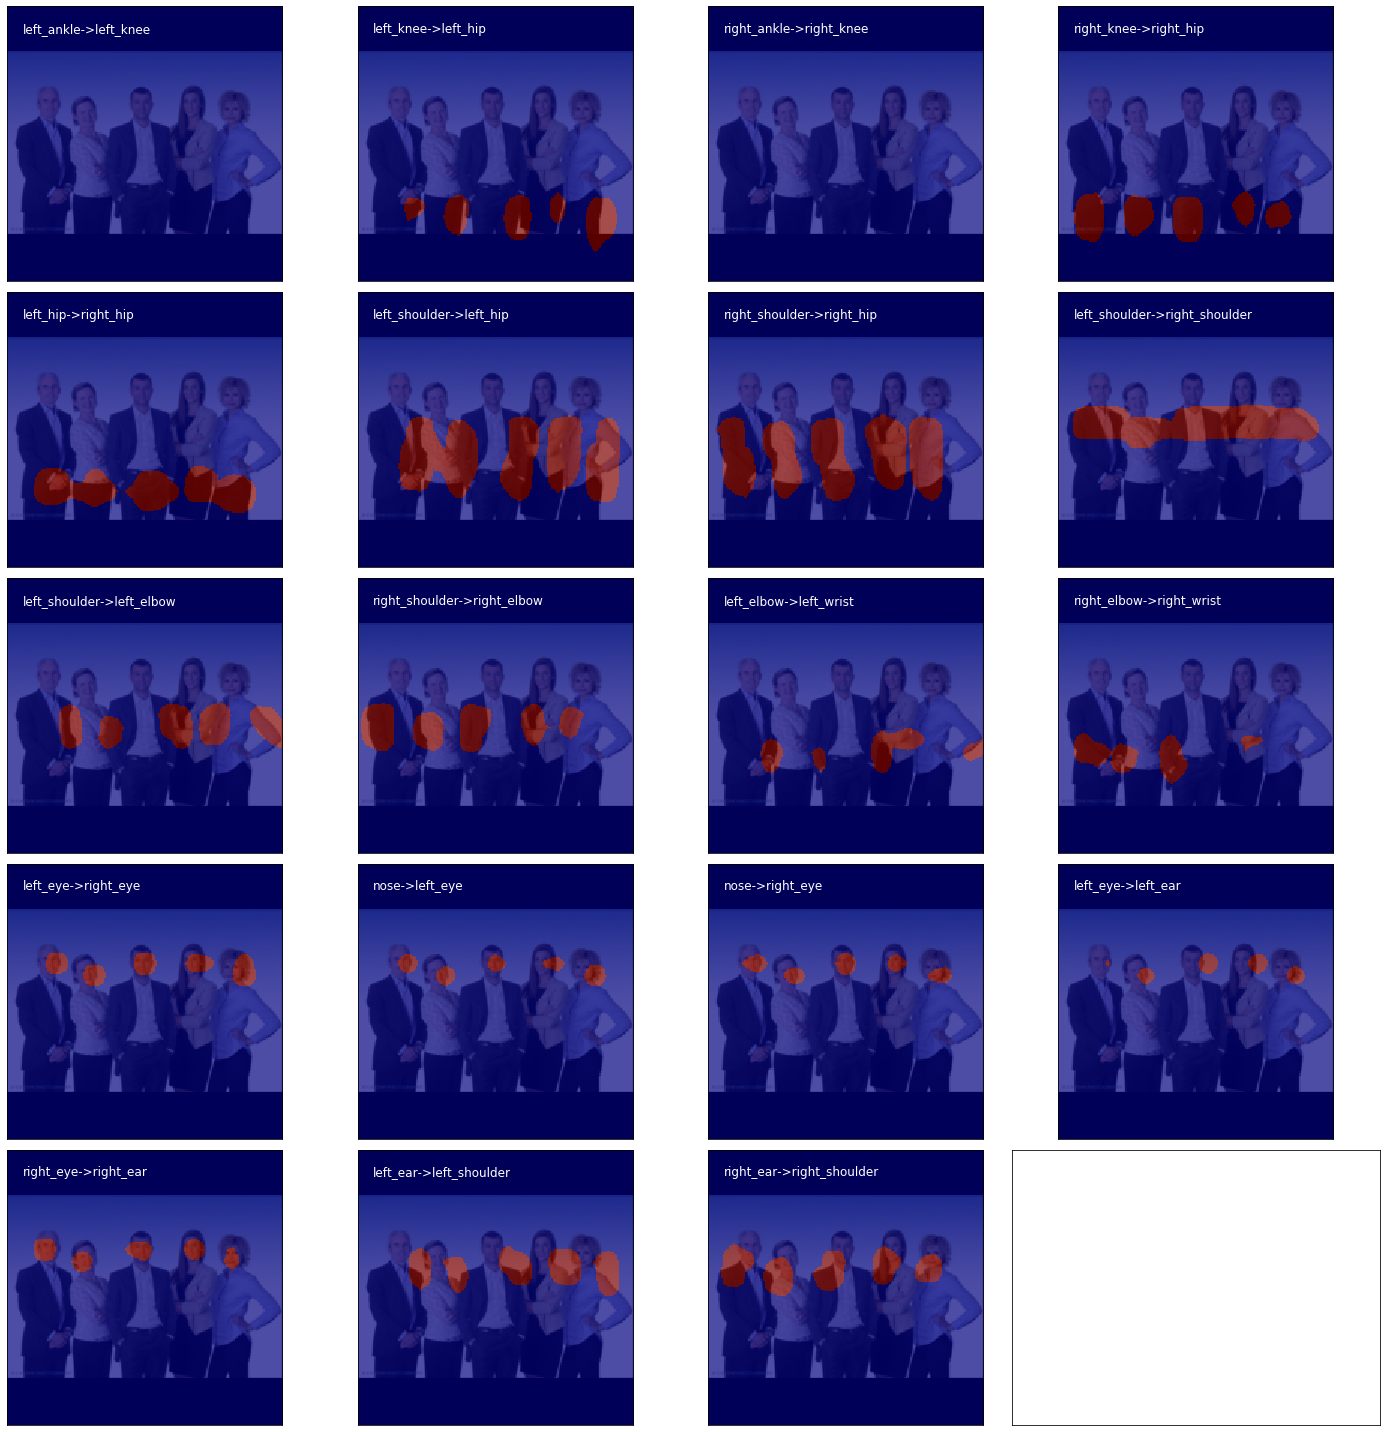

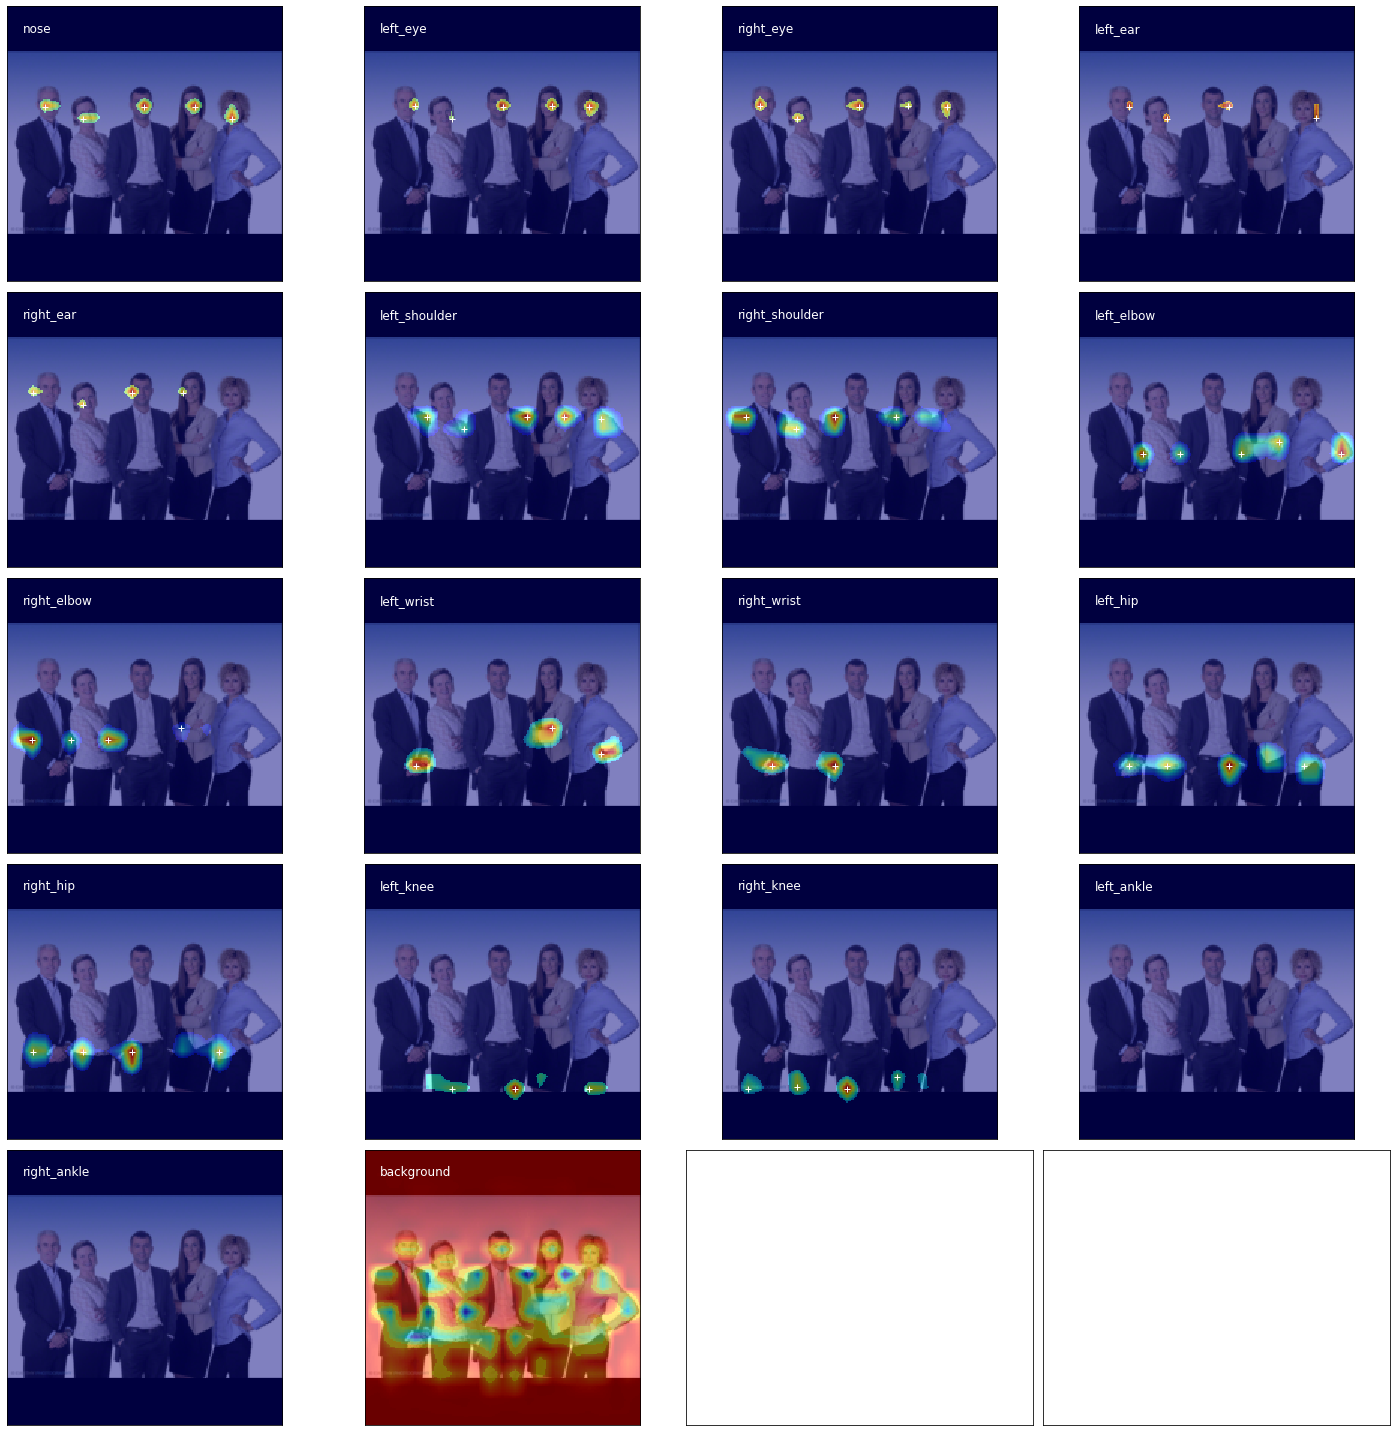

In [26]:
idx = 0
pf = scaled_pafs[idx].clone()
hm = scaled_hms[idx].clone()
pf[torch.abs(pf)<1e-1] = 0
hm[torch.abs(hm)<3e-1] = 0

un_im = To_Pil(un(im)[0])
plt.imshow(un_im)

plot_utils.plot_pafs(un_im, pf.numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hm.numpy(), figsize=(20,20))

In [20]:
from collections import defaultdict
from CONSTANTS import SKELETON, keypoint_labels
joint_pos_map = model_utils.get_joint_positions(hm.numpy())

In [164]:
from munkres import Munkres, make_cost_matrix, DISALLOWED
m = Munkres()

left_knee-->left_hip
0.016972633066286692
0.5682840236686391
0.16
right_knee-->right_hip
0.7825443786982249
0.8663313609467456
0.831744
0.14057242890811023
left_hip-->right_hip
0.5776
0.6944444444444444
0.6760493827160494
0.7579238754325259
left_shoulder-->left_hip
0.9510405098480438
0.6077712003295158
0.9639775026051929
0.9639775026051929
right_shoulder-->right_hip
1.012045258923296
0.656368788119484
0.9377721568066735
0.9669295970019937
left_shoulder-->right_shoulder
1.0
0.9546081087066735
1.0
1.0
left_shoulder-->left_elbow
0.8002661923410695
0.7452405973731431
0.5877777777777777
0.7962130177514792
0.8323527764610522
right_shoulder-->right_elbow
0.9246780984747159
0.7704938271604939
0.5298941618963513
0.8807100591715976
left_elbow-->left_wrist
0.31865968637687736
0.5593365250985074
0.04
right_elbow-->right_wrist
0.6338220800271378
0.9454715522524051
left_eye-->right_eye
0.7901234567901234
0.0
1.0
1.0
0.7901234567901234
nose-->left_eye
0.1960520958876478
0.5377777777777778
0.227455621

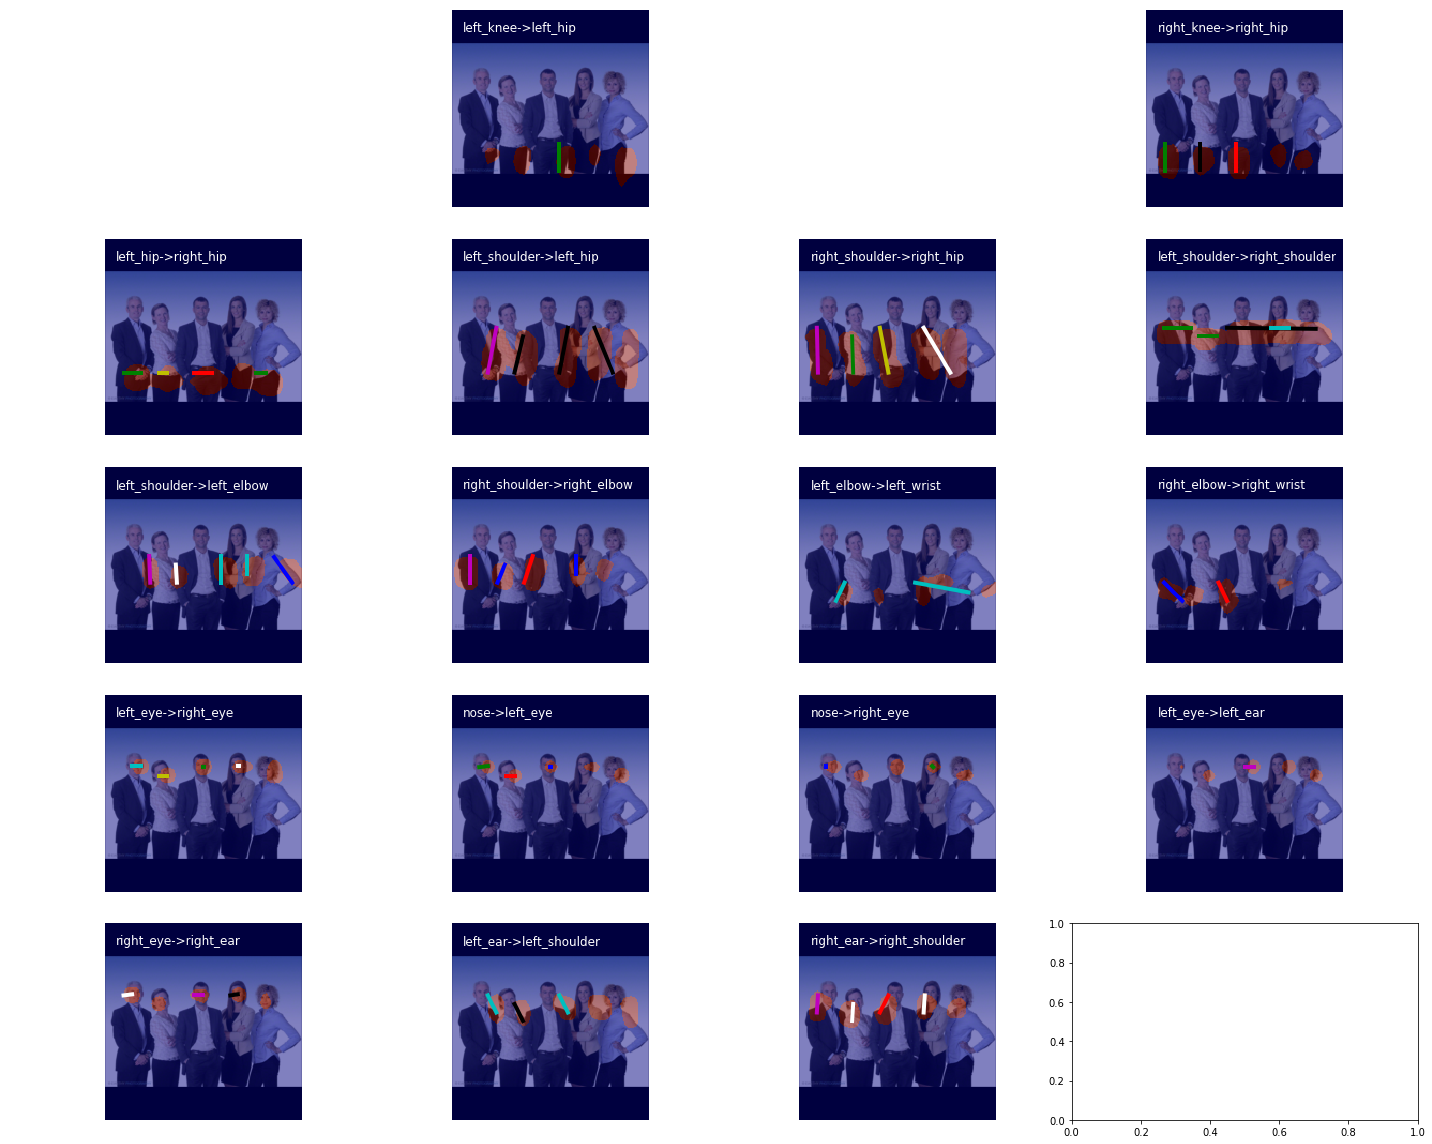

In [169]:
def plot_mask(mask, matching_results, ax, part_pair):
    C,S = ['g','r','b','y','w','c','m','k'], ['o']
    
    ax.axis('off')
    ax.text(10,10, keypoint_labels[part_pair[0]]+'->'+keypoint_labels[part_pair[1]], va='top', color="white", fontsize=12)
    ax.imshow(un_im)
    ax.imshow(mask, 'jet', interpolation='none', alpha=0.5)
    for pt_pair in matching_results:
        pts = np.array(pt_pair)
        ax.plot(pts[:,0], pts[:,1], C[np.random.randint(0,len(C))], linewidth=4) #+S[np.random.randint(0,len(S))]
    

def calculate_affinity_score(j1, j2, paf_map, limb_width):
    score = 0
    ncols_x, nrows_y  = paf_map.shape[1:]
    mask = np.zeros((ncols_x, nrows_y))               
    col, row = np.ogrid[:ncols_x, :nrows_y]
    
    limb_length = np.linalg.norm(j2 - j1)
    match_distance_penalty = 1
    
    if(limb_length>1e-8):
        v = (j2 - j1)/limb_length
        v_perp = np.array([v[1], -v[0]])
        center_point = (j1 + j2)/2
        cond1 = np.abs(np.dot(v, np.array([col, row]) - center_point))<= limb_length/2
        cond2 = np.abs(np.dot(v_perp, np.array([col, row]) - j1))<=limb_width
        
        mask = np.logical_and(cond1, cond2).transpose()
        
        x_s, y_s = np.logical_and(paf_map[0], mask), np.logical_and(paf_map[1], mask)
        non_zero_paf_pixels = np.logical_or(x_s, y_s)
        non_zero_paf_pixels = non_zero_paf_pixels[non_zero_paf_pixels!=0].sum()
        res = np.tensordot(v, np.array([x_s, y_s]), axes=([0], [0]))
        score = (res.sum()*non_zero_paf_pixels)/(mask.sum()*mask.sum())
        
    return np.abs(score)
    
def calculate_affinity_scores(j1_list, j2_list, paf_map, limb_width=2.5):#for 184x184 input     
    h,w = paf_map.shape[1:] 
    affinity_scores = np.zeros((len(j1_list), len(j2_list)))
    j1_list_copy = j1_list.copy().astype(float)
    j2_list_copy = j2_list.copy().astype(float)
    
    for i, j1_pt in enumerate(j1_list):
        for j, j2_pt in enumerate(j2_list):
            affinity_scores[i,j] = calculate_affinity_score(j1_pt, j2_pt, paf_map, limb_width)
            
    return affinity_scores

def compute_matches(affinity_scores, j1_pts, j2_pts):
    matching_results = []
    j1_count, j2_count = affinity_scores.shape
    indices = m.compute(make_cost_matrix(affinity_scores.tolist()))
    
    for row,col in indices:
        print(affinity_scores[row,col])
        if(affinity_scores[row,col]>0.3):
            matching_results.append((j1_pts[row], j2_pts[col]))
    '''
    if(j1_count<j2_count):
        matches = affinity_scores.argmax(axis=1)
        for i in range(len(matches)):
            matching_results.append((j1_pts[i], j2_pts[matches[i]]))
    else:
        matches = affinity_scores.argmax(axis=0)
        for i in range(len(matches)):
            matching_results.append((j1_pts[matches[i]], j2_pts[i]))
    '''
    return matching_results

matches = defaultdict(lambda:[])
MASTER_scores = defaultdict(lambda:[])
fig, axes = plt.subplots(5, 4, figsize=(20,16))

for i, part_pair in enumerate(SKELETON): #SKELETON
    j1_id, j2_id = part_pair
    j1_list = joint_pos_map[j1_id]
    j2_list = joint_pos_map[j2_id]
    affinity_scores = []
    
    if(len(j1_list) and len(j2_list)):        
        affinity_scores = calculate_affinity_scores(j1_list, j2_list, pf[(2*i):(2*i)+2].numpy())
    MASTER_scores[tuple((keypoint_labels[j1_id], keypoint_labels[j2_id]))] = affinity_scores    
    
    if(len(affinity_scores)):
        print(keypoint_labels[j1_id]+'-->'+ keypoint_labels[j2_id])
        matching_results = compute_matches(affinity_scores, joint_pos_map[j1_id], joint_pos_map[j2_id])

        px, py = pf[(2*i)].numpy(), pf[(2*i)+1].numpy()
        plot_mask(np.logical_or(px, py), matching_results, axes.flat[i], part_pair)
    
    else:
        axes.flat[i].figsize=(1,1)
        axes.flat[i].axis('off')
        

plt.tight_layout()        

In [41]:
joint_pos_map[keypoint_type_to_idx['left_shoulder']]

array([[ 91.,  92.],
       [166.,  83.]])

In [42]:
joint_pos_map[keypoint_type_to_idx['right_shoulder']]

array([[ 17., 100.],
       [108.,  83.]])

In [44]:
MASTER_scores[('left_shoulder', 'right_shoulder')]

array([[0.97070435, 0.46030621],
       [0.9735497 , 0.99661017]])

In [40]:
from CONSTANTS import *

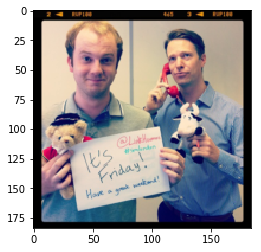

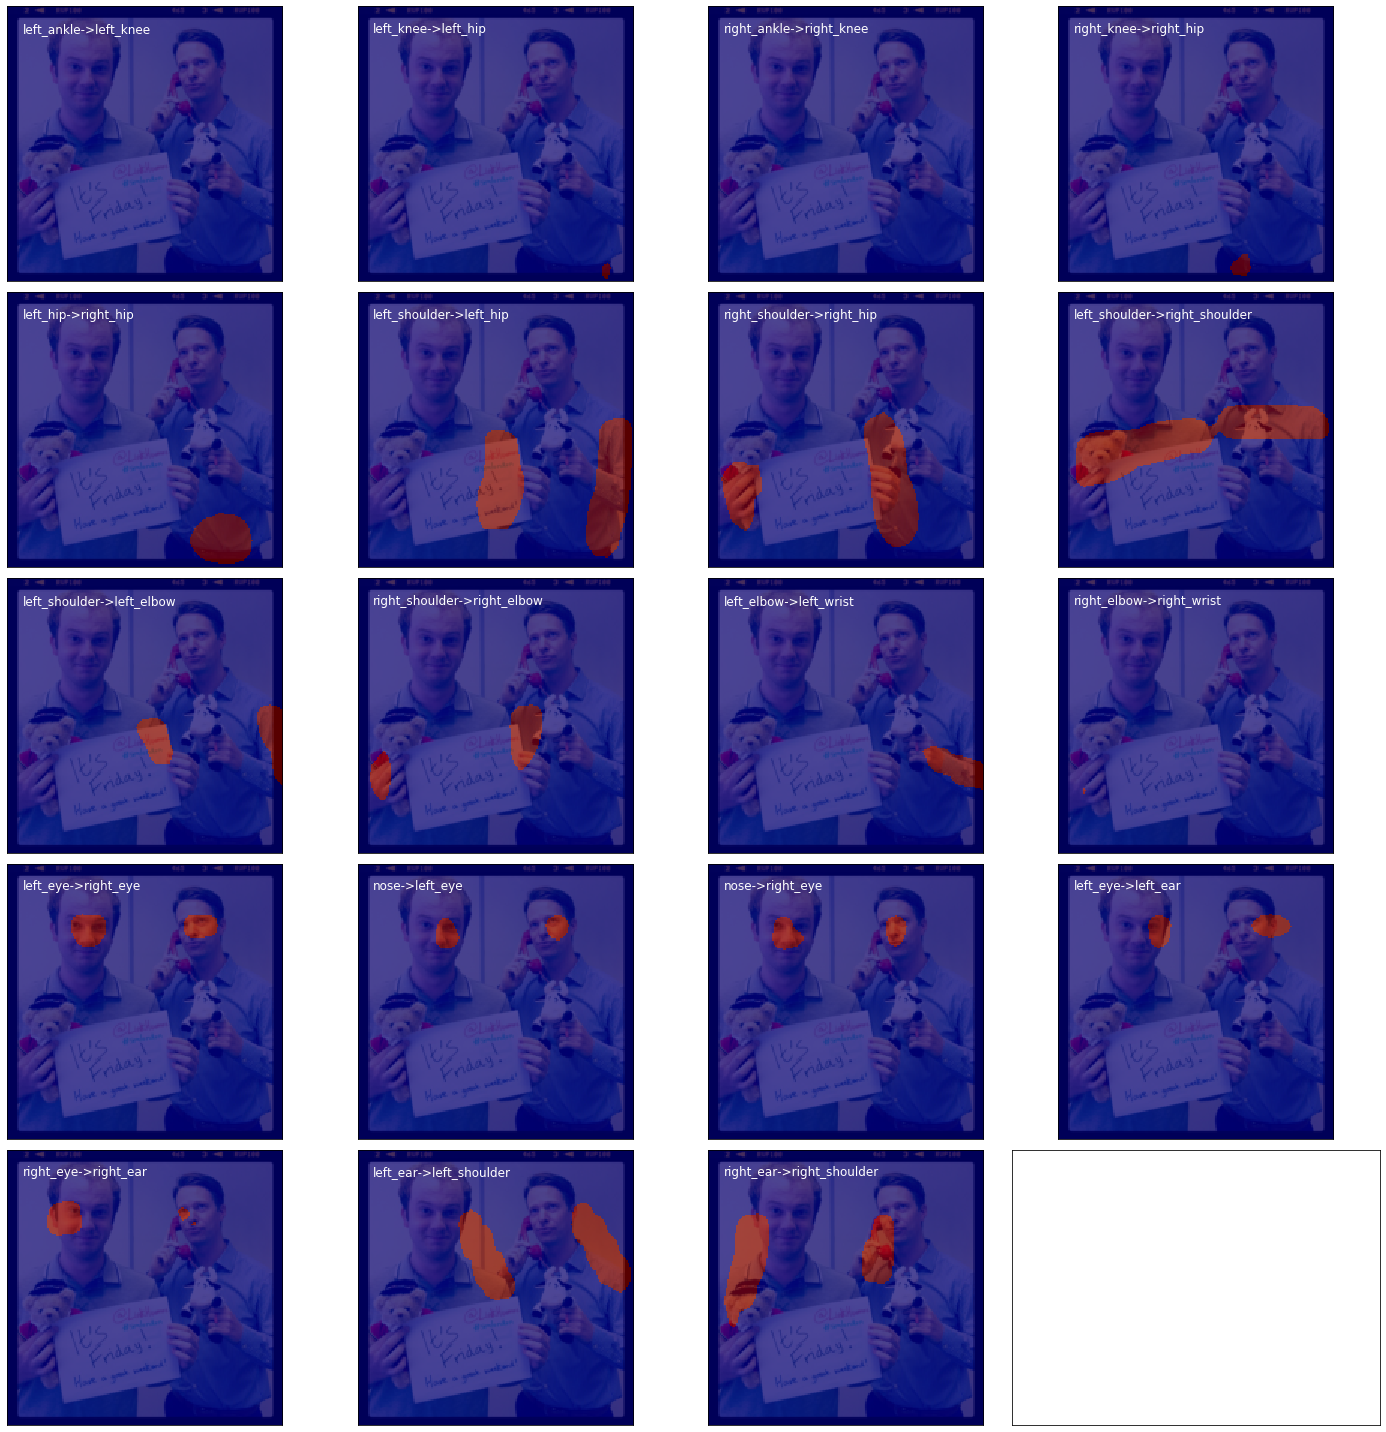

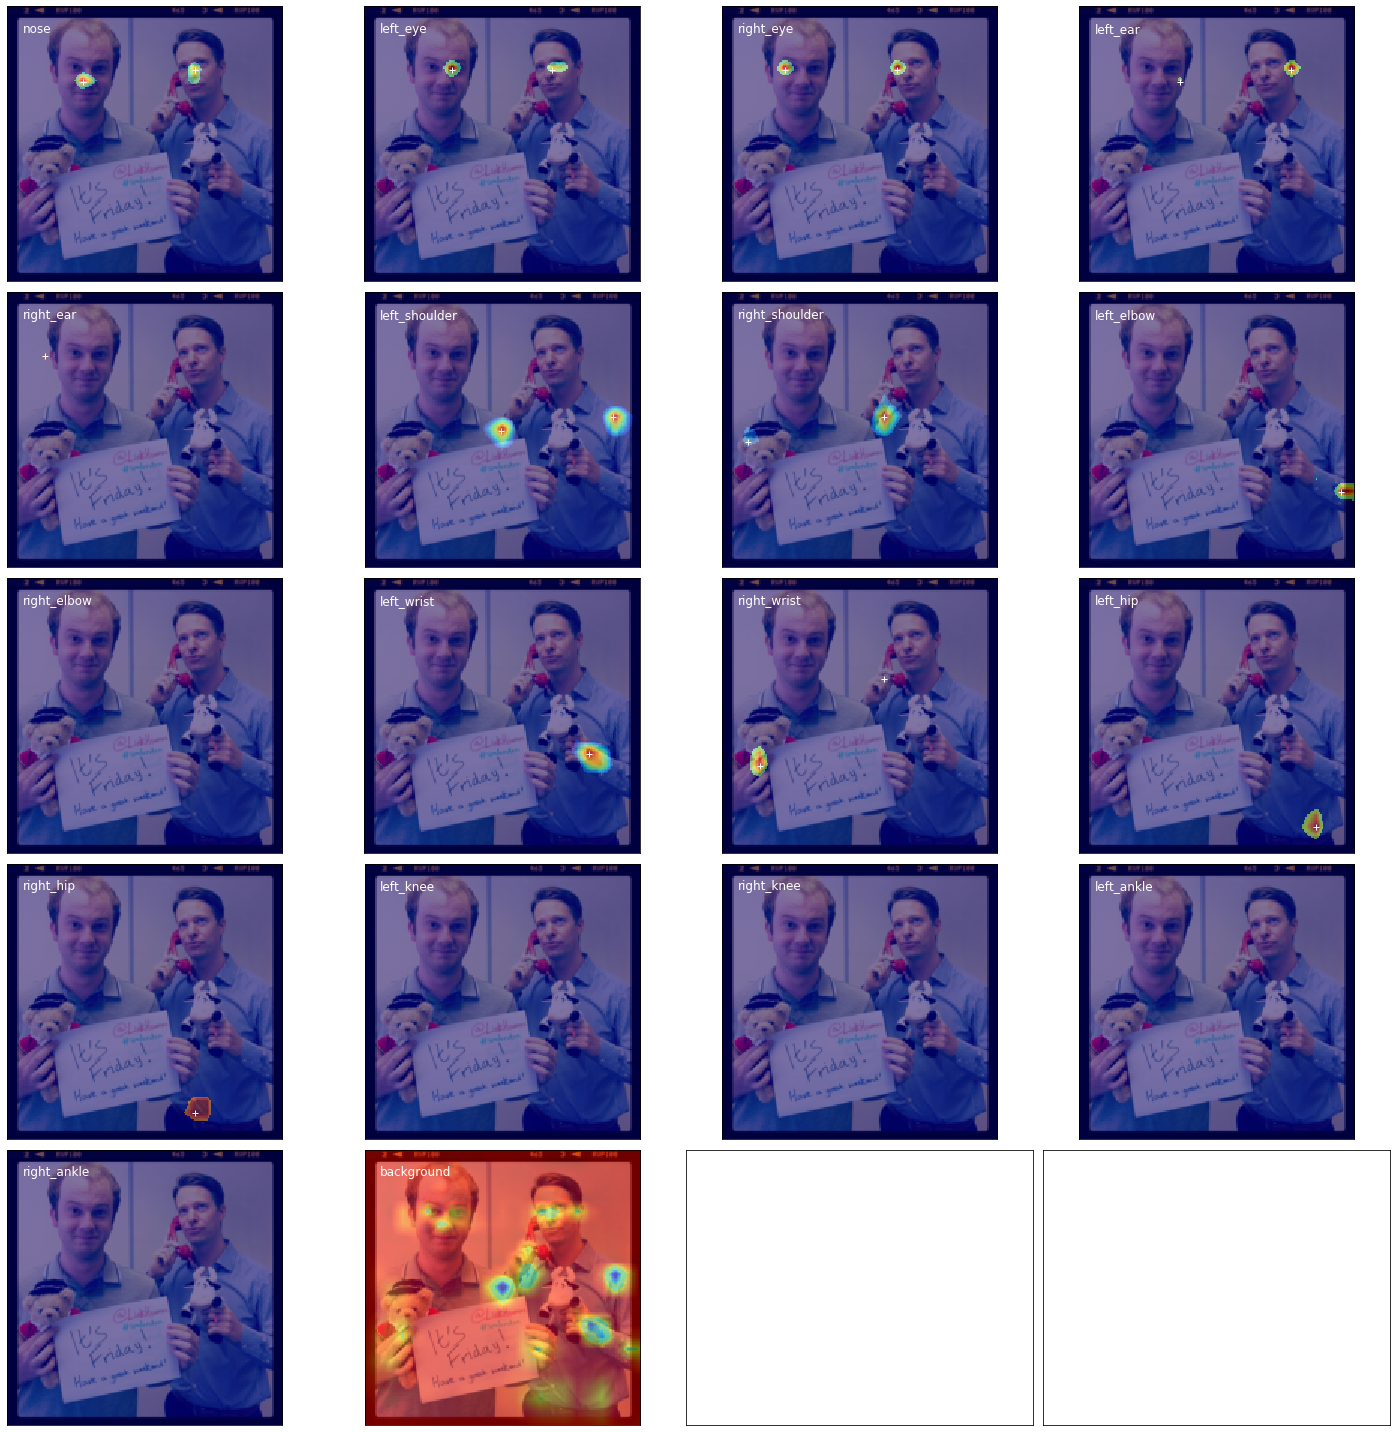

In [ ]:
i,i_46x46,pafs,paf_ind,hms,hms_ind = ds[0]
scaled_pafs = F.interpolate(pafs[None].clone().detach(), 368, mode="nearest").to(device)[0] #mode="nearest|area"
#scaled_hms = F.interpolate(hms[None].clone().detach(), 368, mode="bilinear", align_corners=True).to(device)[0]
un_im = p(un(i)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, scaled_pafs.numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hms.numpy(), figsize=(20,20))